In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import time

import torch.nn as nn
import torch.optim as optim

from scipy.interpolate import interp1d

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=30)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [15]:
## Construct a neural network to approximate the dynamics of an ODE
class ODEFuncMean(nn.Module):

    def __init__(self):
        super(ODEFuncMean, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcMean = ODEFuncMean().to(device)

class ODEFuncVariance(nn.Module):

    def __init__(self):
        super(ODEFuncVariance, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcVariance = ODEFuncVariance().to(device)

class ODEFuncSkewness(nn.Module):

    def __init__(self):
        super(ODEFuncSkewness, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcSkewness = ODEFuncSkewness().to(device)

class ODEFuncKurtosis(nn.Module):

    def __init__(self):
        super(ODEFuncKurtosis, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcKurtosis = ODEFuncKurtosis().to(device)

In [16]:
funcMeanLoaded = torch.load('meanFromNN.pth')
funcSkwLoaded = torch.load('skewnessFromNN.pth')
funcVarLoaded = torch.load('varianceFromNN.pth')
funcKurtLoaded = torch.load('kurtosisFromNN.pth')

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

matrix= scipy.io.loadmat("/home/ponnana/PhD/Yinling_copy/data_new.mat")

m = matrix["data_new"][:,0]
v =  matrix["data_new"][:,1]
s = matrix["data_new"][:,2]
k = matrix["data_new"][:,3]

tExp = [0.01058, 0.03158, 0.05258, 0.07358, 0.09458, 0.1156, 0.1366, 0.1576, 0.1786, 0.1996, 0.2206,
          0.2300, 0.2756, 0.3316, 0.3876, 0.4436, 0.4496, 0.5556, 0.6116, 0.6676, 0.7206, 0.7796, 0.8356,
          0.8916, 0.9476, 1.004, 1.060, 1.105, 1.124, 1.153, 1.182, 1.211, 1.240, 1.269, 1.298, 1.327,
          1.356, 1.385, 1.414, 1.443, 1.472, 1.501, 1.530, 1.559, 1.588, 1.617, 1.646, 1.670]

tExp = np.array(tExp)


t1,t2 = 0.24,1.1
xExp = np.concatenate((matrix["data_new"], tExp.reshape(-1,1)), axis=1)
# xExp = xExp.astype(double)

maxValues = np.max(xExp,axis=0)
maxValues[-1]=1
xExpNormal = xExp/maxValues
truncIndex = np.where(xExpNormal[:,1]>=0.0999)
xExpTruncNormal = xExpNormal[truncIndex,:]
xExpTruncNormal = np.squeeze(xExpTruncNormal)

tExpTrunc = xExpTruncNormal[:,-1]

from scipy.interpolate import interp1d
tTrain = np.linspace(np.min(tExpTrunc), np.max(tExpTrunc), args.data_size)
quad_interp = interp1d(tExpTrunc, xExpTruncNormal, kind='quadratic', axis=0)
xTrain = quad_interp(tTrain)

## Setting up the true system
true_y0 = torch.from_numpy(xTrain[0,:]).to(device).to(dtype=torch.double)
t = torch.from_numpy(tTrain).to(dtype=torch.double)
true_y = torch.from_numpy(xTrain).unsqueeze(1).to(dtype=torch.double)

def combined_system(tVar, y):
    
    dt_dt = 1.0
    dt_dt = torch.tensor([dt_dt])
    
    dm_dt =  funcMeanLoaded(tVar, y)
    
    dv_dt = funcVarLoaded(tVar, y)
   
    ds_dt = funcSkwLoaded(tVar, y)
       
    dk_dt = funcKurtLoaded(tVar, y)
       
    return torch.cat([dm_dt, dv_dt, ds_dt, dk_dt, dt_dt], dim=0)

In [18]:
# Initial state
y0 = true_y0
#y0= torch.tensor([ 0,  0.5, 0, 0])

# Time point for prediction
t_value = t
with torch.no_grad():
    predicted_states = odeint(combined_system,y0 , t).to(device)
    
predicted_states=predicted_states.numpy()

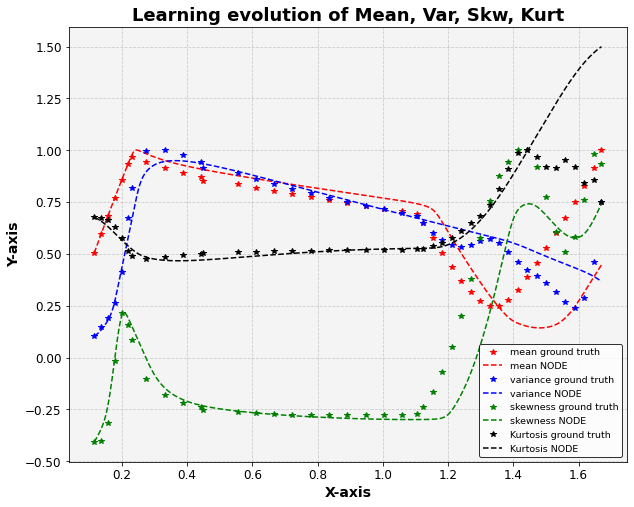

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(tExpTrunc,xExpTruncNormal[:,0], 'r*',label='mean ground truth')
plt.plot(tTrain,predicted_states[:,0], 'r--',label='mean NODE')

plt.plot(tExpTrunc,xExpTruncNormal[:,1], 'b*',label='variance ground truth')
plt.plot(tTrain,predicted_states[:,1], 'b--',label='variance NODE')

plt.plot(tExpTrunc,xExpTruncNormal[:,2], 'g*',label='skewness ground truth')
plt.plot(tTrain,predicted_states[:,2], 'g--',label='skewness NODE')

plt.plot(tExpTrunc,xExpTruncNormal[:,3], 'k*',label='Kurtosis ground truth')
plt.plot(tTrain,predicted_states[:,3], 'k--',label='Kurtosis NODE')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Learning evolution of Mean, Var, Skw, Kurt", fontsize=18, fontweight='bold')
ax.set_xlabel("X-axis", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=9.5)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

plt.savefig('NN_individualFromNN_expt.pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [20]:
y0Part1 = torch.from_numpy(xExpTruncNormal[0,:]).to(device).to(dtype=torch.float)

In [12]:
t = np.linspace(min(tExpTrunc),max(tExpTrunc),1000)

In [13]:
def combined_system1(t, y):
    dt_dt = 1;
    dt_dt = torch.tensor([dt_dt])
    output_tensor = func1Trained(t, y)  # Using ODEFunc to get dx2/dt, dx3/dt, dx4/dt
    return torch.cat([output_tensor,dt_dt], dim=0)

def combined_system2(t, y):
    dt_dt = 1;
    dt_dt = torch.tensor([dt_dt])
    output_tensor = func2Trained(t, y)  # Using ODEFunc to get dx2/dt, dx3/dt, dx4/dt
    return torch.cat([output_tensor,dt_dt], dim=0)

def combined_system3(t, y):
    dt_dt = 1;
    dt_dt = torch.tensor([dt_dt])
    output_tensor = func3Trained(t, y)  # Using ODEFunc to get dx2/dt, dx3/dt, dx4/dt
    return torch.cat([output_tensor,dt_dt], dim=0)


In [57]:
t1 = t[np.where(t<=tBreak1)]
print(t1[-1])
t2 = t[np.where((t>tBreak1) & (t<=tBreak2))]
print(t2[0])
print(t2[0]-t1[-1])
print("size of t2 =" ,np.size(t2))
t2 = np.append(t1[-1],t2)
print("size of t2 =" ,np.size(t2))
print("difference",t2[0]-t1[-1])

0.22918478478478477
0.23074074074074075
0.0015559559559559788
size of t2 = 562
size of t2 = 563
difference 0.0


In [88]:
clear t1, t2, t3, a, b

In [89]:
t1 = t[np.where(t<=tBreak1)]
t1 = torch.from_numpy(t1).to(dtype=torch.float)

t2 = t[np.where((t>tBreak1) & (t<=tBreak2))]
t2 = np.append(t1[-1],t2)
t2 = torch.from_numpy(t2).to(dtype=torch.float)

t3 = t[np.where(t>tBreak2)]
t3 = np.append(t2[-1],t3)
t3 = torch.from_numpy(t3).to(dtype=torch.float)

In [90]:
with torch.no_grad():
    predicted_states1 = odeint(combined_system1,y0Part1, t1).to(device)

In [91]:
y0Part2=predicted_states1[-1]

In [92]:
with torch.no_grad():
    predicted_states2 = odeint(combined_system2,y0Part2, t2).to(device)

In [93]:
y0Part3=predicted_states2[-1]

In [94]:
with torch.no_grad():
    predicted_states3 = odeint(combined_system3,y0Part3, t3).to(device)

In [95]:
predicted_states1=np.squeeze(predicted_states1.numpy())
predicted_states2=predicted_states2.numpy()
predicted_states3=predicted_states3.numpy()

In [113]:
t1 = t1.numpy()
t2 = t2.numpy()
t3 = t3.numpy()

In [114]:
meanPred = np.concatenate((predicted_states1[:,0],predicted_states2[:,0],predicted_states3[:,0]), axis=0)
varPred = np.concatenate((predicted_states1[:,1],predicted_states2[:,1],predicted_states3[:,1]), axis=0)
skwPred = np.concatenate((predicted_states1[:,2],predicted_states2[:,2],predicted_states3[:,2]), axis=0)
kurtPred = np.concatenate((predicted_states1[:,3],predicted_states2[:,3],predicted_states3[:,3]), axis=0)
tPlot = np.concatenate((t1,t2,t3),axis=0)

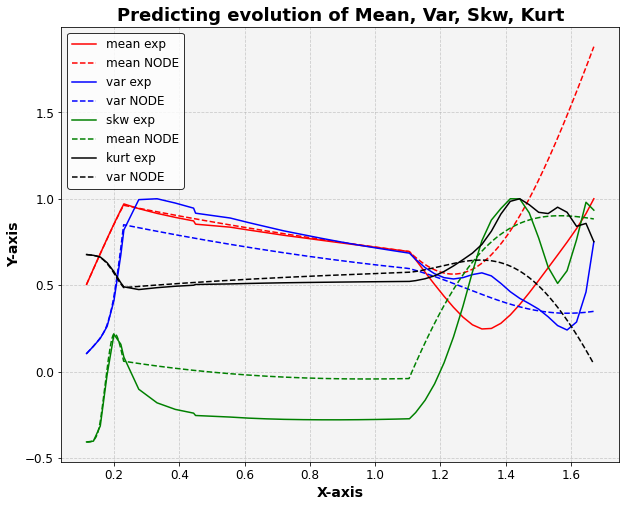

In [130]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(tExpTrunc,xExpTruncNormal[:,0], 'r',label='mean exp')
plt.plot(tPlot,meanPred, 'r--',label='mean NODE')

plt.plot(tExpTrunc,xExpTruncNormal[:,1], 'b',label='var exp')
plt.plot(tPlot,varPred, 'b--',label='var NODE')

plt.plot(tExpTrunc,xExpTruncNormal[:,2], 'g',label='skw exp')
plt.plot(tPlot,skwPred, 'g--',label='mean NODE')

plt.plot(tExpTrunc,xExpTruncNormal[:,3], 'k',label='kurt exp')
plt.plot(tPlot,kurtPred, 'k--',label='var NODE')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Predicting evolution of Mean, Var, Skw, Kurt", fontsize=18, fontweight='bold')
ax.set_xlabel("X-axis", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='upper left', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

plt.savefig('Predicting.pdf', bbox_inches='tight')

# Show the plot
plt.show()
